# Fake News Detection with Adversarial Normalization

Notebook with implemenation and testing for applying Adversarial Neural Networks to the task of Fake News Detection. Part of the project for Northeastern University's Khoury College course on Practical Neural Networks (DS 4440), during Fall 2020.

This notebook begins cleaning and preprocesing the data from FakeNewsCorpus.


Note: this notebook expects the data to be used to be located on a Google Drive account on a specific path. This *can* be modified.

See README at https://github.com/pablokvitca/ds4440-project for more details.

In [ ]:
# Imports
import pandas as pd
import numpy as np
import ast
from time import time
from collections import Counter

In [ ]:
# Data path
path = "./data/news_cleaned.csv"

In [ ]:
cols = [
 # '',
 # 'id',
 'domain',
 'type',
 # 'url',
 'content',
 # 'scraped_at',
 # 'inserted_at',
 'updated_at',
 'title',
 'authors',
 # 'keywords',
 'meta_keywords',
 # 'meta_description',
 'tags',
 # 'summary',
 # 'source'
]

In [ ]:
coltypes = {
 # '': np.int32,
 # 'id': np.int32,
 'domain': np.str,
 'type': np.str,
 # 'url': np.str,
 'content': np.str,
 # 'scraped_at': np.str,
 # 'inserted_at': np.str,
 # 'updated_at': np.str,
 'title': np.str,
 'authors': np.str,
 # 'keywords': np.str,
 'meta_keywords': np.str,
 # 'meta_description': np.str,
 'tags': np.str,
 # 'summary': np.str,
 # 'source': np.str
}

In [ ]:
data = pd.read_csv(path, nrows=5_000_000, low_memory=True, memory_map=True, encoding="utf-8", quotechar='"', engine="c", usecols=cols, dtype=coltypes, error_bad_lines=False, warn_bad_lines=True)

/Users/pablokvitca/anaconda3/envs/nn-project/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
data.shape

(5000000, 8)

In [ ]:
data["type"].value_counts()

political                     1421133
bias                           446692
conspiracy                     310923
fake                           246376
2018-02-07 23:39:33.852696     233205
unreliable                     227298
rumor                          185249
clickbait                      141034
unknown                        103485
junksci                         59010
satire                          55674
hate                            53221
2018-02-02 01:19:41.756664      34838
reliable                        15947
2017-11-10T11:18:44.524042      14065
Name: type, dtype: int64

In [ ]:
data.describe()

,domain,type,content,updated_at,title,authors,meta_keywords,tags
count,3771345,3548150,3503302,3757280,3480082,2245762,3489237,1010156
unique,497,15,1931296,12,2231857,211015,410806,523847
top,ecowatch.com,political,Cowry Collective members participate in a time...,2018-02-07 23:39:33.852696,Is Palm Oil Explosion Driving Ebola Outbreak?,"Backgroundurl Avatar_Large, Nickname, Joined, ...",[''],View Tags
freq,746529,1421133,285230,2091105,32763,224948,2210754,163065


In [ ]:
data.drop(data[data.type == "2018-02-07 23:39:33.852696"].index, inplace=True)
data.drop(data[data.type == "2018-02-02 01:19:41.756664"].index, inplace=True)
data.drop(data[data.type == "2017-11-10T11:18:44.524042"].index, inplace=True)

In [ ]:
data.describe()

,domain,type,content,updated_at,title,authors,meta_keywords,tags
count,3489237,3266042,3489237,3489237,3466017,2231697,3489237,1010156
unique,494,12,1931295,2,2231856,211014,410806,523847
top,ecowatch.com,political,Cowry Collective members participate in a time...,2018-02-07 23:39:33.852696,Is Palm Oil Explosion Driving Ebola Outbreak?,"Backgroundurl Avatar_Large, Nickname, Joined, ...",[''],View Tags
freq,746529,1421133,285230,2091105,32763,224948,2210754,163065


In [ ]:
data.shape

(4717892, 8)

In [ ]:
data.type.describe()

count       3266042
unique           12
top       political
freq        1421133
Name: type, dtype: object

In [ ]:
data.type.value_counts()

political     1421133
bias           446692
conspiracy     310923
fake           246376
unreliable     227298
rumor          185249
clickbait      141034
unknown        103485
junksci         59010
satire          55674
hate            53221
reliable        15947
Name: type, dtype: int64

In [ ]:
def get_all_unique_from_list_col(df, col, f):
    l = set()
    for u in df[col].unique():
        if type(u) == str:
            l.update(f(u))
    return l

all_keywords = get_all_unique_from_list_col(data, "meta_keywords", ast.literal_eval)
all_tags = get_all_unique_from_list_col(data, "tags", lambda x: x.split(", "))
all_authors = get_all_unique_from_list_col(data, "authors", lambda x: x.split(", "))

In [ ]:
print("Total keywords:", len(all_keywords))
print("Total tags:", len(all_tags))
print("Total authors:", len(all_authors))

Total keywords: 432375
Total tags: 469962
Total authors: 141914


In [ ]:
counts_keywords = Counter()
for row in data["meta_keywords"]:
    if type(row) == str:
        counts_keywords.update(ast.literal_eval(row.lower()))

In [ ]:
non_relevant_keywords = ["", "featured", "featured-home"]
for nrk in non_relevant_keywords:
    del counts_keywords[nrk]

In [ ]:
counts_keywords.most_common(100)

[('climate change', 313727),
 ('business', 258123),
 ('energy', 220365),
 ('renewables', 192477),
 ('health', 105349),
 ('food', 100328),
 ('biodiversity', 98606),
 ('sustainable business', 97040),
 ('coal', 75628),
 ('fracking', 74660),
 ('politics', 73086),
 ('science', 66711),
 ('china', 42220),
 ('ebola', 33690),
 ('cuba', 33528),
 ('cop21', 32877),
 ('pipelines', 32852),
 ('russia', 32836),
 ('tips', 32300),
 ('transportation', 31966),
 ('donald trump', 26632),
 ('united states', 23972),
 ('barack obama', 20173),
 ('hillary clinton', 17902),
 ('economics', 17598),
 ('news', 15564),
 ('big government', 14772),
 ('finance', 14703),
 ('markets', 14647),
 ('analysis', 14429),
 ('zerohedge', 14215),
 ('zero hedge', 14210),
 ('wikileaks', 12538),
 ('syria', 12478),
 ('world', 12245),
 ('vdare.com', 11642),
 ('national security', 10905),
 ('the onion', 10163),
 ('media', 9834),
 ('ohio', 9492),
 ('white house', 9176),
 ('bernie sanders', 8878),
 ('natural medicine', 8797),
 ('functional 

In [ ]:
counts_tags = Counter()
for row in data["tags"]:
    if type(row) == str:
        counts_tags.update([s.strip() for s in row.lower().split(", ")])

In [ ]:
non_relevant_tags = [
    "view tags", 
    "next", 
    "4062 followers duggar family", 
    "3756 followers sylvester stallone", 
    "view non-amp version", 
    "1",
    "4217 followers dragon ball super",
    "2",
    ]
for nrt in non_relevant_tags:
    del counts_tags[nrt]

In [ ]:
counts_tags.most_common(100)

[('russia', 65416),
 ('donald trump', 60004),
 ('hillary clinton', 42836),
 ('syria', 35145),
 ('9/11 articles', 31523),
 ('race/crime articles', 31523),
 ('american pravda articles', 31523),
 ('race/iq articles', 31523),
 ('israel', 31399),
 ('libya', 30813),
 ('united states', 30101),
 ('immigration', 29121),
 ('politics', 28905),
 ('barack obama', 25986),
 ('trump', 25812),
 ('obama', 24607),
 ('isis', 24055),
 ('europe', 23574),
 ('iran', 23016),
 ('china', 22821),
 ('cia', 22379),
 ('benghazi', 22064),
 ('children', 21172),
 ('terrorism', 20555),
 ('islam', 20424),
 ('north korea', 19914),
 ('irs', 19148),
 ('epa', 18967),
 ('iraq', 18534),
 ('school', 17817),
 ('transportation', 17659),
 ('financial disclosure', 17637),
 ('hillary clinton email scandal', 17531),
 ('trump administration', 17399),
 ('religion', 17373),
 ('irs docs', 17369),
 ('ukraine', 17339),
 ('turkey', 17327),
 ('retirement', 17115),
 ('foia', 17001),
 ('vanguard', 16725),
 ('middle east', 16680),
 ('india', 16

In [ ]:
counts_authors = Counter()
for row in data["authors"]:
    if type(row) == str:
        counts_authors.update([s.strip() for s in row.lower().split(", ")])

In [ ]:
counts_authors.most_common(100)

[('lorraine chow', 746451),
 ('common dreams', 638516),
 ('guest contributor', 507058),
 ('the conversation', 384011),
 ('david leestma', 362631),
 ('yes', 285256),
 ('environmental working group', 254739),
 ('ronnie cummins', 254659),
 ('the climate reality project', 254658),
 ('sierra club', 254636),
 ('rainforest action network', 254636),
 ('backgroundurl avatar_large', 224956),
 ('nickname', 224956),
 ('joined', 224956),
 ('created_at', 224956),
 ('story count', 224956),
 ('n_stories', 224956),
 ('comment count', 224956),
 ('n_comments', 224956),
 ('popular tags', 224956),
 ('showtags popular_tags', 224948),
 ('organic consumers association', 156531),
 ("our children's trust", 107978),
 ('american wild horse campaign', 107975),
 ('anastasia pantsios', 101821),
 ('stefanie spear', 98031),
 ('climate nexus', 82670),
 ('daily kos', 76786),
 ('happy cog studios - http', 76783),
 ('www.happycog.com', 76783),
 ('david codrea', 70085),
 ('tom mchale', 70085),
 ('jeff knox', 70085),
 ('the

In [ ]:
non_relevant_authors = [
    "yes", 
    "nickname", 
    "joined", 
    "created_at", 
    "story count", 
    "n_stories", 
    "comment count", 
    "n_comments", 
    "popular tags", 
    "showtags popular_tags", 
    "the",
    "view all posts",
    "http",
    "https",
    "",
    "background",
    "ffffff",
    "solid",
    "border-style",
    "color",
    "border-color"
    "border-top-width",
    "border-right-width",
    "about me"
]
for nra in non_relevant_authors:
    del counts_authors[nra]

In [ ]:
fake_types = [
#     "political",
#     "bias",
    "conspiracy",
    "fake",
    "unreliable",
    "rumor",
    "clickbait",
#     "unknown",
    "junksci",
    "satire",
    "hate",
    "reliable"]
data["fake"] = data.type.apply(lambda x: 1 if x in fake_types else 0)

In [ ]:
data["fake"].value_counts()

0    3492328
1    1225564
Name: fake, dtype: int64

In [ ]:
data.dropna(subset=['type', 'content', 'title', 'fake'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [ ]:
def add_metadata_as_has_col(df, col, all_metadata, prefix, cache):
    start_time = int(time() * 1000)
    n = len(all_metadata)
    for i, metadata in enumerate(all_metadata):
        print("Processed {} of {} metadata keys ({} ms)".format(i, n, int(time() * 1000) - start_time))
        df[prefix + metadata[0]] = df.apply(lambda row: 1 if row.name < len(cache) and metadata[0] in cache[row.name] else 0, axis=1)

In [ ]:
mt = set()
cache_keywords = [set([a for a in ast.literal_eval(d.lower()) if a not in non_relevant_keywords]) if type(d) == str else mt for d in data["meta_keywords"]]
cache_tags = [set([s.strip() for s in d.lower().split(", ") if s.strip() not in non_relevant_tags]) if type(d) == str else mt for d in data["tags"]]
cache_authors = [set([s.strip() for s in d.lower().split(", ") if s.strip() not in non_relevant_authors]) if type(d) == str else mt for d in data["authors"]]

In [ ]:
add_metadata_as_has_col(data, "meta_keywords", counts_keywords.most_common(100), "has_mk_", cache_keywords)

Processed 0 of 100 metadata keys (0 ms)
Processed 1 of 100 metadata keys (21077 ms)
Processed 2 of 100 metadata keys (35318 ms)
Processed 3 of 100 metadata keys (50004 ms)
Processed 4 of 100 metadata keys (64100 ms)
Processed 5 of 100 metadata keys (76604 ms)
Processed 6 of 100 metadata keys (91258 ms)
Processed 7 of 100 metadata keys (105581 ms)
Processed 8 of 100 metadata keys (120714 ms)
Processed 9 of 100 metadata keys (135215 ms)
Processed 10 of 100 metadata keys (151352 ms)
Processed 11 of 100 metadata keys (167289 ms)
Processed 12 of 100 metadata keys (188125 ms)
Processed 13 of 100 metadata keys (208006 ms)
Processed 14 of 100 metadata keys (235591 ms)
Processed 15 of 100 metadata keys (273240 ms)
Processed 16 of 100 metadata keys (307341 ms)
Processed 17 of 100 metadata keys (348034 ms)
Processed 18 of 100 metadata keys (374767 ms)
Processed 19 of 100 metadata keys (406861 ms)
Processed 20 of 100 metadata keys (433860 ms)
Processed 21 of 100 metadata keys (464682 ms)
Processed

In [ ]:
add_metadata_as_has_col(data, "tags", counts_tags.most_common(100), "has_tag_", cache_tags)

Processed 0 of 100 metadata keys (0 ms)
Processed 1 of 100 metadata keys (68484 ms)
Processed 2 of 100 metadata keys (136612 ms)
Processed 3 of 100 metadata keys (198915 ms)
Processed 4 of 100 metadata keys (263275 ms)
Processed 5 of 100 metadata keys (330590 ms)
Processed 6 of 100 metadata keys (400550 ms)
Processed 7 of 100 metadata keys (473139 ms)
Processed 8 of 100 metadata keys (535256 ms)
Processed 9 of 100 metadata keys (610366 ms)
Processed 10 of 100 metadata keys (678515 ms)
Processed 11 of 100 metadata keys (745561 ms)
Processed 12 of 100 metadata keys (808199 ms)
Processed 13 of 100 metadata keys (873415 ms)
Processed 14 of 100 metadata keys (937324 ms)
Processed 15 of 100 metadata keys (1004537 ms)
Processed 16 of 100 metadata keys (1069731 ms)
Processed 17 of 100 metadata keys (1140947 ms)
Processed 18 of 100 metadata keys (1217419 ms)
Processed 19 of 100 metadata keys (1291306 ms)
Processed 20 of 100 metadata keys (1373393 ms)
Processed 21 of 100 metadata keys (1459196 m

In [ ]:
add_metadata_as_has_col(data, "authors", counts_authors.most_common(100), "has_author_", cache_authors)

Processed 0 of 100 metadata keys (0 ms)
Processed 1 of 100 metadata keys (121219 ms)
Processed 2 of 100 metadata keys (232432 ms)
Processed 3 of 100 metadata keys (350367 ms)
Processed 4 of 100 metadata keys (474430 ms)
Processed 5 of 100 metadata keys (587165 ms)
Processed 6 of 100 metadata keys (697572 ms)
Processed 7 of 100 metadata keys (819189 ms)
Processed 8 of 100 metadata keys (927804 ms)
Processed 9 of 100 metadata keys (1055699 ms)
Processed 10 of 100 metadata keys (1184626 ms)
Processed 11 of 100 metadata keys (1306438 ms)
Processed 12 of 100 metadata keys (1439123 ms)
Processed 13 of 100 metadata keys (1566228 ms)
Processed 14 of 100 metadata keys (1688539 ms)
Processed 15 of 100 metadata keys (1835166 ms)
Processed 16 of 100 metadata keys (1972478 ms)
Processed 17 of 100 metadata keys (2114796 ms)
Processed 18 of 100 metadata keys (2249995 ms)
Processed 19 of 100 metadata keys (2377976 ms)
Processed 20 of 100 metadata keys (2521906 ms)
Processed 21 of 100 metadata keys (26

In [ ]:
data.drop("meta_keywords", axis=1, inplace=True)
data.drop("tags", axis=1, inplace=True)
data.drop("authors", axis=1, inplace=True)

In [ ]:
simple_cols = ["title", "content", "type", "fake", "domain", "updated_at"]

In [ ]:
data.to_csv("./data/news_wkta_all.csv", index=False)
data.to_csv("./data/news_simple_all.csv", columns=simple_cols, index=False)

In [ ]:
medium_data = data.sample(n=2_500_000, random_state=9034)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
medium_data.to_csv("./data/news_wkta_2500k.csv", index=False)
medium_data.to_csv("./data/news_simple_2500k.csv", columns=simple_cols, index=False)

In [ ]:
small_data.to_csv("./data/news_wkta_500k.csv", index=False)
small_data.to_csv("./data/news_simple_500k.csv", columns=simple_cols, index=False)

In [ ]:
small_data.type.value_counts(normalize=True)

political     0.438336
bias          0.137570
conspiracy    0.088278
fake          0.075482
unreliable    0.070096
rumor         0.057772
clickbait     0.043410
unknown       0.032048
junksci       0.018404
satire        0.017164
hate          0.016508
reliable      0.004932
Name: type, dtype: float64

In [ ]:
medium_data.type.value_counts(normalize=True)

political     0.438166
bias          0.137713
conspiracy    0.088793
fake          0.075884
unreliable    0.069976
rumor         0.057370
clickbait     0.043462
unknown       0.031926
junksci       0.018195
satire        0.017166
hate          0.016407
reliable      0.004943
Name: type, dtype: float64

In [ ]:
data = pd.read_csv("./data/news_wkta_500k.csv.zip", low_memory=True, memory_map=True, encoding="utf-8", quotechar='"', engine="c", dtype=coltypes, error_bad_lines=False, warn_bad_lines=True)

In [ ]:
def recover_meta_counts(df, prefix):
    counts = Counter()
    for col in df.columns:
        if prefix in col:
            data_slice = df[df[col] == 1]
            counts[col[len(prefix):]] += data_slice[col].sum()
    return counts

In [ ]:
counts_keywords = recover_meta_counts(data, "has_mk_")
counts_tags = recover_meta_counts(data, "has_tag_")
counts_authors = recover_meta_counts(data, "has_author_")

In [ ]:
def filter_data_by_meta(df, prefix, meta_counts, n):
    req_cols = [prefix + meta for meta, _ in meta_counts.most_common(n)]
    
    all_criteria = [df[col] == 1 for col in req_cols]
    criteria = df[req_cols[0]] == 1
    for col in req_cols[1:]:
        criteria = criteria | df[col] == 1
        
    return df.loc[criteria]
    
    

In [ ]:
filtered_data = filter_data_by_meta(data, "has_mk_", counts_keywords, 25)

In [ ]:
data.fake.value_counts(normalize=True)

0    0.629394
1    0.370606
Name: fake, dtype: float64

In [ ]:
filtered_data.fake.value_counts(normalize=True)

0    0.957647
1    0.042353
Name: fake, dtype: float64

<AxesSubplot:>

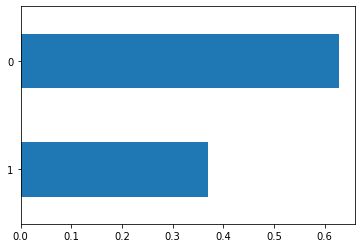

In [ ]:
data.fake.value_counts(normalize=True).sort_values().plot(kind = 'barh')

<AxesSubplot:>

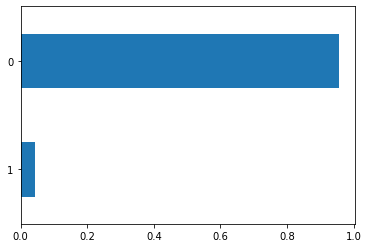

In [ ]:
filtered_data.fake.value_counts(normalize=True).sort_values().plot(kind = 'barh')

In [ ]:
tiny_data = filtered_data.sample(n=25_000, random_state=9034)

In [ ]:
tiny_data.to_csv("./data/news_simple_25k.csv", columns=simple_cols, index=False)

In [ ]:
tiny_data.to_csv("./data/news_wkta_25k.csv", index=False)

In [ ]:
smaller_data = filtered_data.sample(n=50_000, random_state=9034)

In [ ]:
smaller_data.to_csv("./data/news_simple_50k.csv", columns=simple_cols, index=False)

In [ ]:
smaller_data.to_csv("./data/news_wkta_50k.csv", index=False)

In [ ]:
small_data = filtered_data.sample(n=100_000, random_state=9034)

In [ ]:
small_data.to_csv("./data/news_simple_100k.csv", columns=simple_cols, index=False)

In [ ]:
small_data.to_csv("./data/news_wkta_100k.csv", index=False)

In [ ]:
import sys
original_stdout = sys.stdout # Save a reference to the original standard output
with open('./data/metadata_counts.txt', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(counts_keywords, counts_tags, counts_authors, sep="\n")
    sys.stdout = original_stdout # Reset the standard output to its original value